# Comparison of PLM representations under different settings

In [2]:
library(tidyverse)
library(mgsub)
library(lsa) #cosine

library(stringr)

library(RColorBrewer)
library(ggplot2)
library(corrplot)
library(patchwork)
library(ggbeeswarm)

In [3]:
lowerTriangle <- function(m){
  return(m[lower.tri(m,diag = FALSE)])
}

## Modern

In [5]:
human_258r_sim = read.csv('human_rating_data/human_model/human_33d_258r_cosine.csv',fileEncoding = 'gb18030', row.names=1,check.names=FALSE)
rels_modern_order = rownames(human_258r_sim) 
human_258r_sim_array = lowerTriangle(human_258r_sim)

In [7]:
querys = dir('sim_bert_embedding/modern/')
for (query in querys){
    bert_cor_df = data.frame(matrix(nrow=13,ncol=4)) # layer = 12 + output
    colnames(bert_cor_df) = c('query','layer','position','r_value')
    
    ### 1.import all files in each quesy
    files = dir(paste0('sim_bert_embedding/modern/',query,'/'))
    count = 1
    for (file in files){
        bert_sim = read.csv(paste0('sim_bert_embedding/modern/',query,'/',file), 
                           row.names=1, check.names = FALSE, fileEncoding = 'gb18030')
        colnames(bert_sim) = rownames(bert_sim)
        bert_sim = bert_sim[rels_modern_order, rels_modern_order]
        bert_sim_array = lowerTriangle(bert_sim)

        ### 2. caculate spearman correlation between huamn rating and bert embedding
        human_bert_sim = cbind(human_258r_sim_array, bert_sim_array)
        r_value = cor(human_bert_sim, method = 'spearman')[1,2]

        ### 3.store r value results in dataframe
        layer = strsplit(strsplit(file,'_')[[1]][3],'.csv')[[1]]
        position = strsplit(file,'_')[[1]][1]
        if (grepl('layer',layer)){layer=layer}
            else{layer='hidden'}
        bert_cor_df[count,1] = query
        bert_cor_df[count,2] = layer
        bert_cor_df[count,3] = position
        bert_cor_df[count,4] = r_value        
        count = count + 1
    }
    write.csv(bert_cor_df,paste0('human_bert_cor/modern/',query,'.csv'))
    print(query)    
}

[1] "q1.1_bert_embedding_data"
[1] "q1.2_bert_embedding_data"
[1] "q2.1_bert_embedding_data"
[1] "q2.2_bert_embedding_data"
[1] "q3.1_bert_embedding_data"
[1] "q3.2_bert_embedding_data"
[1] "q4.0_bert_embedding_data"


In [8]:
querys = dir('sim_bert_embedding/modern/')
all_cor_df = data.frame(matrix(ncol=4))
colnames(all_cor_df) = c('query','layer','position','r_value')

for (query in querys){
    cor_df = read.csv(paste0('human_bert_cor/modern/',query,'.csv'),row.names=1)
    all_cor_df = rbind(all_cor_df, cor_df)
    all_cor_df = na.omit(all_cor_df)
    all_cor_df$'query' = str_extract(all_cor_df$'query', "q[0-9]\\.[0-9]+")
} 

CLS_cor_df = all_cor_df[all_cor_df$'position'=='CLS',]
MASK_cor_df = all_cor_df[all_cor_df$'position'=='MASK',]
relationship_cor_df = all_cor_df[all_cor_df$'position'=='关系',]

In [9]:
my.color = c('q1.1'= '#FC8002','q1.2'='#FABB6E',
             'q2.1'='#882d9f','q2.2'='#c488db',
             'q3.2'='#EE4431','q3.1'='#B9181A',#'q3.3'='#FAC7B3',
             'q4.0'='#CEDFEF','q4.1'='#CEDFEF','q4.2'='#4995C6','q4.3'='#92C2DD')

my.alpha = c('q1.1'= 0.5,'q2.2'=0.5,
            'q1.2'=0.5, 'q3.1'=1,
            'q2.1'=0.5,'q3.2'=0.5,#'q3.3'=0.5,
             'q4.0'=0.5,'q4.2'=0.5,'q4.3'=0.5)

In [10]:
Plot_sim_trend = function(df){
    df = df %>% 
        #mutate(layer = str_replace(layer, "(\\d+)$", function(m) as.character(as.numeric(m) + 1)))
        mutate(layer = as.numeric(str_extract(layer, "\\d+")) + 1)  %>% na.omit()

    #layers = df[grep('layer',df$layer),]
    layers = df
    layers$layer = factor(layers$layer, levels=seq(1,24))
    #layers$query = factor(layers$query, levels=rev(paste0('q',seq(1,6))))
    options(repr.plot.width=8,repr.plot.height=3.5)
    p = ggplot(layers, aes(x=layer, y =r_value, group=query,color=query,alpha=query))+
        geom_line(size=1.5)+
        geom_point(size=5)+
        scale_color_manual(values = my.color) +                          
        scale_alpha_manual(values = my.alpha) +   
    
        scale_y_continuous(breaks=seq(0,0.7,0.1),limits=c(0,0.7))+

        #coord_flip() +
        #ylim(c(0,0.75))+
        theme_minimal()+
        theme(#legend.position = 'none',
              axis.title = element_blank(),
              axis.text = element_text(size=20,color="black"),
              axis.line = element_line(linetype=1,color="black",size=1.5),
              plot.title = element_text(size = 20, face = "bold",hjust = 0.5))
    return(p)
    }

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


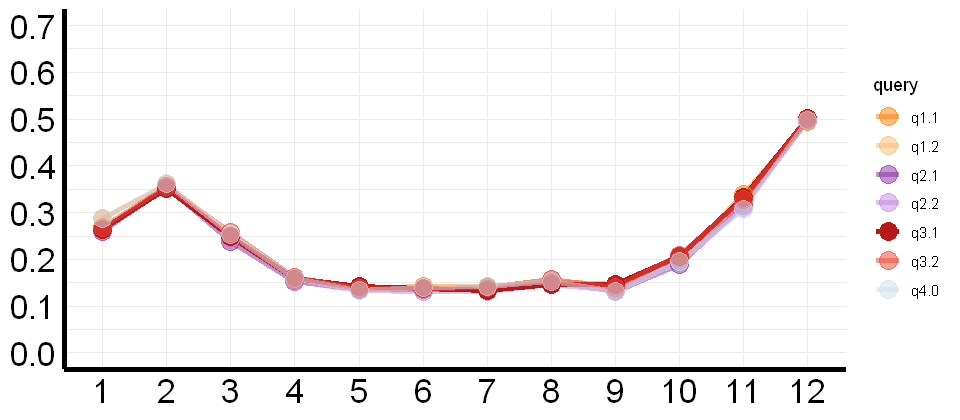

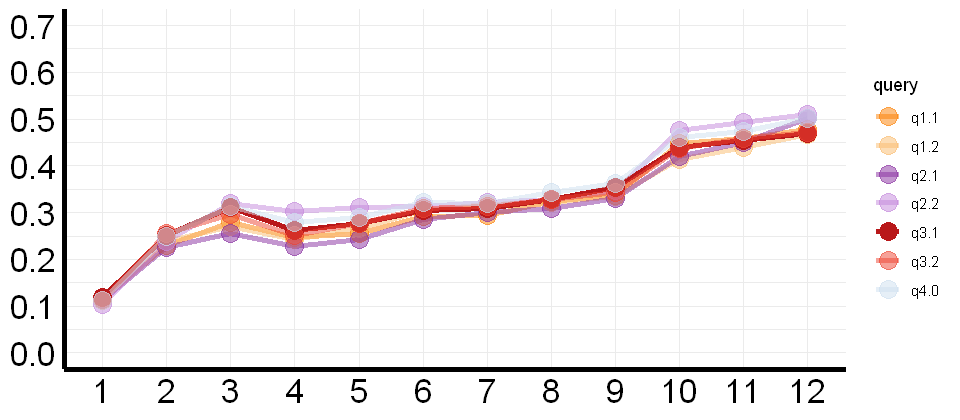

In [11]:
Plot_sim_trend(CLS_cor_df)
Plot_sim_trend(relationship_cor_df)

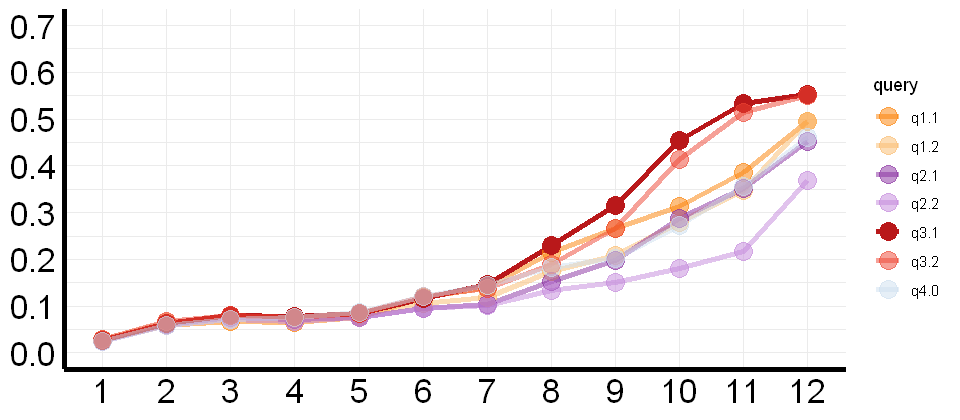

In [12]:
Plot_sim_trend(MASK_cor_df)

In [13]:
png("output_graph/mask_embedding/modern_MASK.png", bg="transparent",
    family = 'sans',units='in',width=8,height=3.5,res=300)
Plot_sim_trend(MASK_cor_df)
dev.off()

png 
  2

## Ancient

In [15]:
human_120r_sim = read.csv('../../Expert_reliability/output_data/sim_matrix/expert_120r_sim_cosine.csv',
                          fileEncoding = 'gb18030', row.names=1,check.names=FALSE)
rels_ancient_order = rownames(human_120r_sim) 
human_120r_sim_array = lowerTriangle(human_120r_sim)

In [16]:
querys = dir('sim_bert_embedding/ancient/')
for (query in querys){
    bert_cor_df = data.frame(matrix(nrow=13,ncol=4)) # layer = 24 + output
    colnames(bert_cor_df) = c('query','layer','position','r_value')
    
    ### 1.import all files in each quesy
    files = dir(paste0('sim_bert_embedding/ancient/',query,'/'))
    count = 1
    for (file in files){
        bert_sim = read.csv(paste0('sim_bert_embedding/ancient/',query,'/',file), 
                           row.names=1, check.names = FALSE, fileEncoding = 'gb18030')
        colnames(bert_sim) = rownames(bert_sim)
        bert_sim = bert_sim[rels_ancient_order, rels_ancient_order]
        bert_sim_array = lowerTriangle(bert_sim)

        ### 2. caculate spearman correlation between huamn rating and bert embedding
        human_bert_sim = cbind(human_120r_sim_array, bert_sim_array)
        r_value = cor(human_bert_sim, method = 'spearman')[1,2]

        ### 3.store r value results in dataframe
        layer = strsplit(strsplit(file,'_')[[1]][3],'.csv')[[1]]
        position = strsplit(file,'_')[[1]][1]
        if (grepl('layer',layer)){layer=layer}
            else{layer='hidden'}
        bert_cor_df[count,1] = query
        bert_cor_df[count,2] = layer
        bert_cor_df[count,3] = position
        bert_cor_df[count,4] = r_value        
        count = count + 1
    }
    write.csv(bert_cor_df,paste0('human_bert_cor/ancient/',query,'.csv'))
    print(query)    
}

[1] "q1.1_bert_embedding_data"
[1] "q1.2_bert_embedding_data"
[1] "q2.1_bert_embedding_data"
[1] "q2.2_bert_embedding_data"
[1] "q3.1_bert_embedding_data"
[1] "q3.2_bert_embedding_data"
[1] "q3.3_bert_embedding_data"
[1] "q4.1_bert_embedding_data"
[1] "q4.2_bert_embedding_data"
[1] "q4.3_bert_embedding_data"


In [20]:
querys = dir('sim_bert_embedding/ancient/')
all_cor_df = data.frame(matrix(ncol=4))
colnames(all_cor_df) = c('query','layer','position','r_value')

for (query in querys){
    cor_df = read.csv(paste0('human_bert_cor/ancient/',query,'.csv'),row.names=1)
    all_cor_df = rbind(all_cor_df, cor_df)
    all_cor_df = na.omit(all_cor_df)
    all_cor_df$'query' = str_extract(all_cor_df$'query', "q[0-9]\\.[0-9]+")
} 

CLS_cor_df = all_cor_df[all_cor_df$'position'=='CLS',]
MASK_cor_df = all_cor_df[all_cor_df$'position'=='MASK',]
relationship1_cor_df = all_cor_df[all_cor_df$'position'=='關',]
relationship2_cor_df = all_cor_df[all_cor_df$'position'=='系',]
relationship_cor_df = all_cor_df[all_cor_df$'position'=='關系',]

In [17]:
my.color = c('q1.1'= '#FC8002','q1.2'='#FABB6E',
             'q2.1'='#882d9f','q2.2'='#c488db',
             'q3.1'='#EE4431','q3.2'='#B9181A','q3.3'='#FAC7B3',
             'q4.1'='#CEDFEF','q4.2'='#4995C6','q4.3'='#92C2DD')

my.alpha = c('q1.1'= 0.5,'q2.2'=0.5,
            'q1.2'=0.5, 'q3.1'=0.5,
            'q2.1'=0.5,'q3.2'=1,'q3.3'=0.5,
             'q4.0'=0.5,'q4.2'=0.5,'q4.3'=0.5)

In [18]:
Plot_sim_trend = function(df){
    df = df %>% 
        #mutate(layer = str_replace(layer, "(\\d+)$", function(m) as.character(as.numeric(m) + 1)))
        mutate(layer = as.numeric(str_extract(layer, "\\d+")) + 1)  %>% na.omit()

    #layers = df[grep('layer',df$layer),]
    layers = df
    layers$layer = factor(layers$layer, levels=seq(1,12))
    #layers$query = factor(layers$query, levels=rev(paste0('q',seq(1,6))))
    options(repr.plot.width=8,repr.plot.height=3.5)
    p = ggplot(layers, aes(x=layer, y =r_value, group=query,color=query,alpha=query))+
        geom_line(size=1.5)+
        geom_point(size=5)+
        scale_color_manual(values = my.color) +                          
        scale_alpha_manual(values = my.alpha) +   
    
        scale_y_continuous(breaks=seq(0,0.7,0.1),limits=c(0,0.7))+

        #coord_flip() +
        #ylim(c(0,0.75))+
        theme_minimal()+
        theme(legend.position = 'right',
              axis.title = element_blank(),
              axis.text = element_text(size=20,color="black"),
              axis.line = element_line(linetype=1,color="black",size=1.5),
              plot.title = element_text(size = 20, face = "bold",hjust = 0.5))
    return(p)
    }

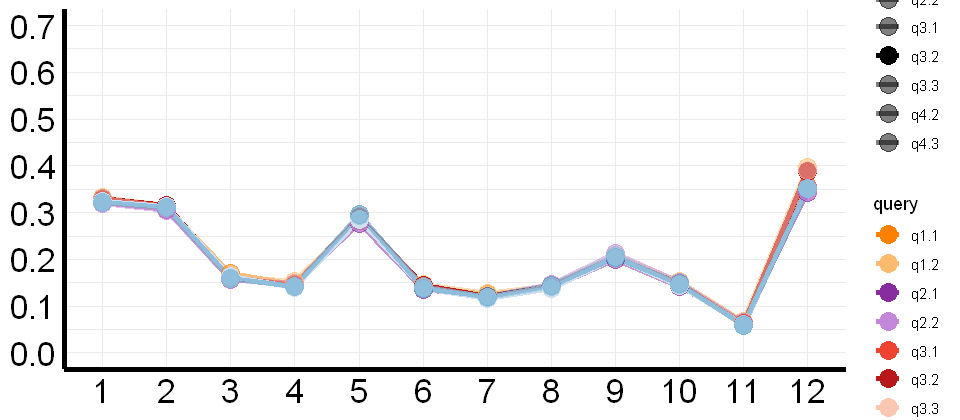

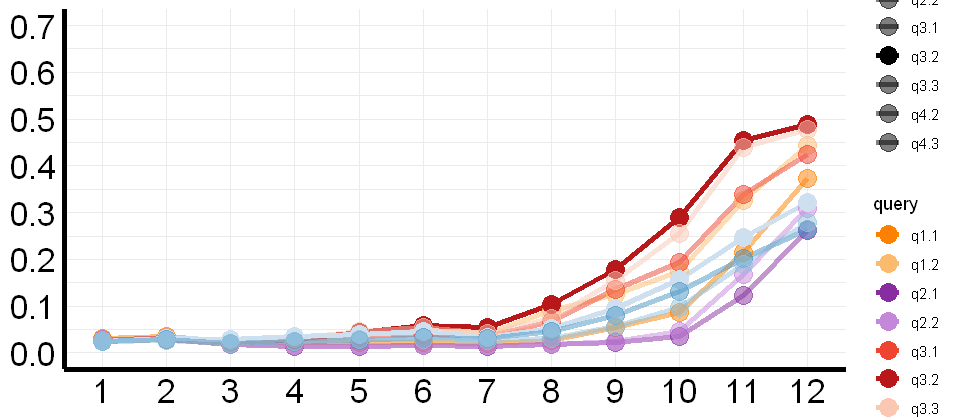

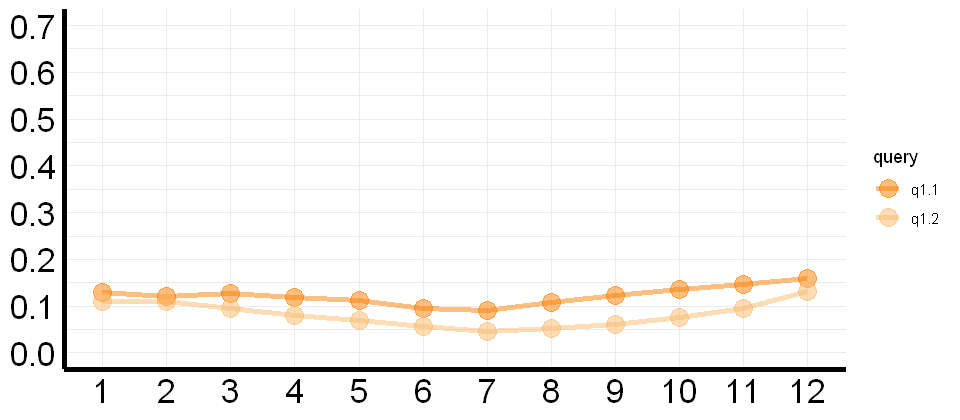

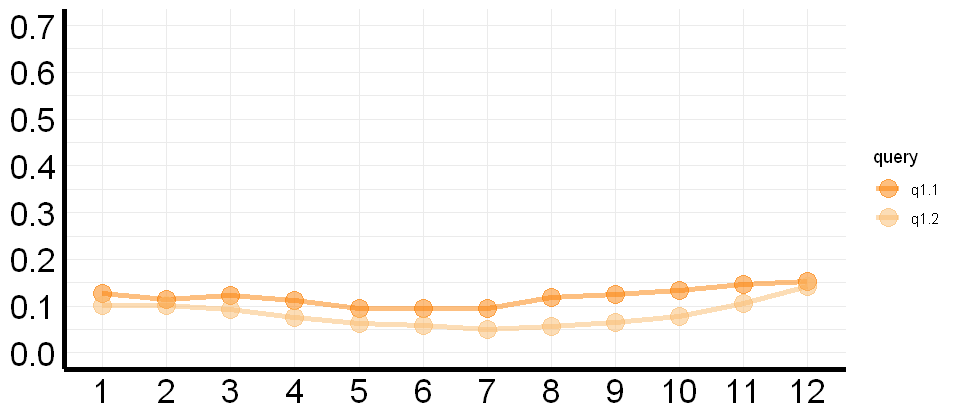

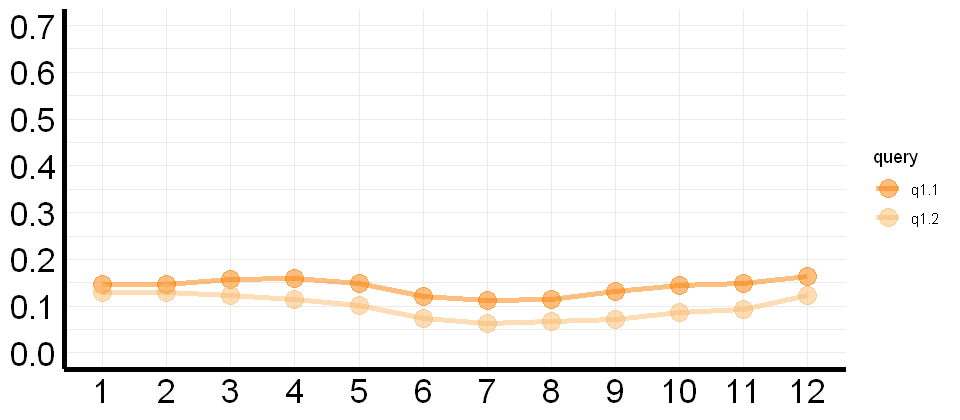

In [21]:
Plot_sim_trend(CLS_cor_df)
Plot_sim_trend(MASK_cor_df)
Plot_sim_trend(relationship_cor_df)
Plot_sim_trend(relationship1_cor_df)
Plot_sim_trend(relationship2_cor_df)

In [22]:
png("output_graph/mask_embedding/ancient_MASK.png", bg="transparent",
    family = 'sans',units='in',width=8,height=3.5,res=300)
Plot_sim_trend(MASK_cor_df)
dev.off()

png 
  2

# Most human-like

## raw order

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

### modern

In [2]:
human_sim = pd.read_csv('human_rating_data/human_model/human_33d_258r_cosine.csv',
                        encoding='gb18030',index_col=0)
bert_sim = pd.read_csv('sim_bert_embedding/modern/q3.1_bert_embedding_data/MASK_embedding_output.csv',
                       encoding='gb18030',index_col=0)

<AxesSubplot:>

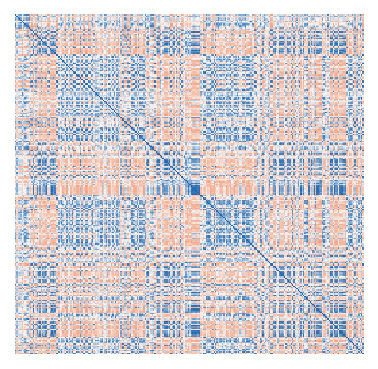

In [3]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(human_sim,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

<AxesSubplot:>

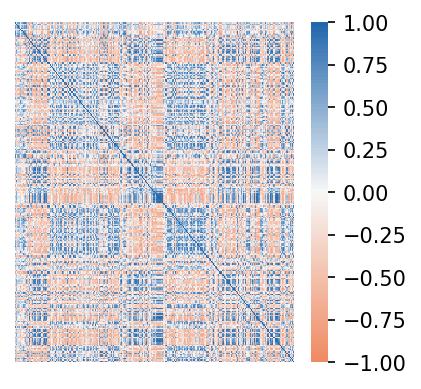

In [4]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(human_sim,xticklabels='',yticklabels='',cmap = cmaps,vmin=-1, vmax=1)

<AxesSubplot:>

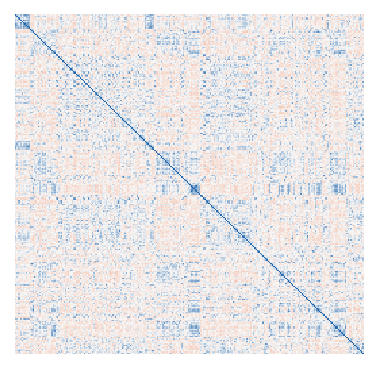

In [5]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(bert_sim,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

### ancient

In [17]:
bert_sim_ancient = pd.read_csv('sim_bert_embedding/ancient/q3.2_bert_embedding_data/MASK_embedding_output.csv',
                       encoding='gb18030',index_col=0)
human_sim_ancient = human_sim.loc[bert_sim_ancient.index,bert_sim_ancient.columns]

modern_rels = list(bert_sim.index)
ancient_in_modern_rels = [i for i in modern_rels if i in bert_sim_ancient.index]
len(ancient_in_modern_rels)

human_sim_ancient = human_sim_ancient.loc[ancient_in_modern_rels,ancient_in_modern_rels]
bert_sim_ancient = bert_sim_ancient.loc[ancient_in_modern_rels,ancient_in_modern_rels]

<AxesSubplot:>

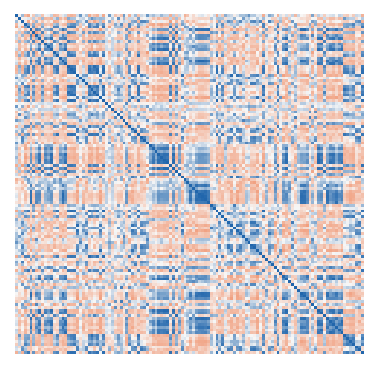

In [18]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(human_sim_ancient,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

<AxesSubplot:>

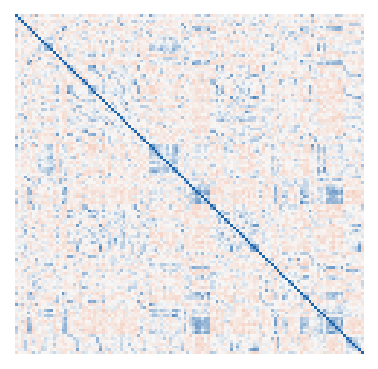

In [19]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(bert_sim_ancient,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

## reorder by clustering results

In [8]:
from sklearn.cluster import KMeans
random_state = 2023

In [10]:
human_df = pd.read_csv('human_rating_data/study2_modern/CHN_dim_rel_NLP_258r_33d_scaled_chi.csv',index_col=0,
                      encoding='gb18030')

model = KMeans(3, random_state=random_state)
model.fit(human_df)

cluster_labels = model.fit_predict(human_df)
human_df['cl_k3'] = cluster_labels

raw_results = human_df
for n in range(len(raw_results['cl_k3'].unique())):
    each_cluster = raw_results.index[raw_results['cl_k3']==n]
    print("\nCluster "+str(n+1)+" Relationship:{}".format(len(each_cluster)))
    print(*raw_results.index[raw_results['cl_k3']==n], sep = ", ")


Cluster 1 Relationship:55
债主-欠债人, 原配-第三者, 网友之间, 外地人-本地人, 乞丐-路人, 搭讪的人-被搭讪的人, 报案人-受害者, 罪犯-旁观者, 罪犯-被害人亲属, 忠臣-反贼, 小偷-失主, 嫌疑人-警察, 受害者-旁观者, 首领-反贼, 施害者-受害者, 胜者-败者, 前同事之间, 冠军-亚军, 官员-行贿者, 对手之间, 对立球队的球员之间, 赌徒之间, 毒贩-警察, 城管-摊贩, 报案人-罪犯, 霸凌者-受害者, 游客-本地人, 情敌之间, 陌生人之间, 对立球队的球迷之间, 出轨者-小三, 罪犯-受害人, 罪犯-警察, 肇事者-交警, 原告-被告, 艺人-黑粉, 前任官员-现任官员, 卖淫者-嫖客, 罪犯 - 人质, 罪犯 - 检察官, 原配-小三, 假朋友之间（表面朋友，实则讨厌对方）, 同一场体育比赛的对手之间（有正面交锋/比赛中的宿敌）, 体育竞赛的对手之间（不一定有正面交锋，比如预赛中不同的球队之间）, 受害者 - 目击者, 奴隶 - 奴隶主, 金主 - 援交男/女, 贩毒者 - 瘾君子, 认识但不熟的人之间, 离婚夫妇之间, 狱警-囚犯, 政治对手之间, 谈判中对立的双方, 生意竞争对手之间, 敌人之间

Cluster 2 Relationship:121
助教-学生, 学生会主席-学生会成员, 社团社长-社团社员, 老师-家长, 考官-考生, 家长-班主任, 家教-学生, 辅导员-大学生, 班主任-学生, 班委-班级成员, 主人-佣人, 主力-替补, 主管-助理, 主持人-观众, 主播-打赏者, 中介-客户, 政府官员-老百姓, 明星-经纪人, 演员-观众, 演员-编剧, 物业-业主, 外卖配送员-顾客, 图书管理员-读者, 售票员-乘客, 收银员-顾客, 收件人-快递员, 赛事解说员-观众, 人事工作人员-员工, 评委-选手, 评委-观众, 律师-检察官, 老员工-新员工, 老板-员工, 客服-顾客, 捐款人-受惠者, 居委会-居民, 教练-学员, 寄件人-快递员, 记者-采访对象, 黑帮老大-小弟, 管家-住户, 公务人员-办事人, 高级员工-低级员工, 法官-检察官, 队长-队员, 导演-编剧, 厨师-顾客, 乘务员-乘客, 编辑-作者, 保姆-雇主, 雇主-保镖, 保安-住户, 访客-前台, 

In [11]:
rels_order = list(human_df.sort_values('cl_k3').index)
human_sim_order = human_sim.loc[rels_order,rels_order]
bert_sim_order = bert_sim.loc[rels_order,rels_order]

<Axes: >

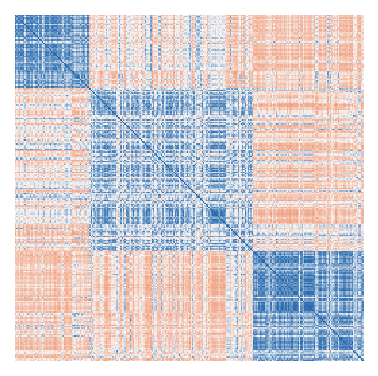

In [12]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(human_sim_order,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

<Axes: >

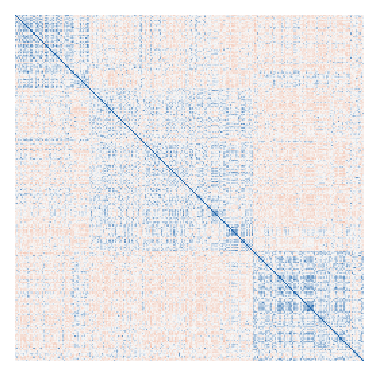

In [13]:
plt.figure(figsize=(3,3),dpi=150)
mycolor = ['#EF8A62','#F7F7F7','#2166AC']
cmaps = mpl.colors.LinearSegmentedColormap.from_list('mylist',mycolor,N=100)
sns.heatmap(bert_sim_order,xticklabels='',yticklabels='',cmap = cmaps,cbar=False,vmin=-1, vmax=1)

In [14]:
modern_bert_df = pd.read_csv('bert_embedding_data/modern/q3.1_bert_embedding_data/MASK_embedding_output.csv',
                       index_col=0,
                      encoding='gb18030')
modern_bert_df.index = modern_bert_df['word']
modern_bert_df = modern_bert_df.drop('word',axis=1)

model = KMeans(3, random_state=random_state)
model.fit(modern_bert_df)

cluster_labels = model.fit_predict(modern_bert_df)
modern_bert_df['cl_k3'] = cluster_labels

raw_results = modern_bert_df
for n in range(len(raw_results['cl_k3'].unique())):
    each_cluster = raw_results.index[raw_results['cl_k3']==n]
    print("\nCluster "+str(n+1)+" Relationship:{}".format(len(each_cluster)))
    print(*raw_results.index[raw_results['cl_k3']==n], sep = ", ")


Cluster 1 Relationship:50
债主和欠债人之间, 原配和第三者之间, 报案人和受害者之间, 罪犯和旁观者之间, 罪犯和被害人亲属之间, 忠臣和反贼之间, 小偷和失主之间, 嫌疑人和警察之间, 受害者和旁观者之间, 首领和反贼之间, 施害者和受害者之间, 胜者和败者之间, 律师和检察官之间, 见义勇为者和受助者之间, 黑帮老大和小弟之间, 官员和行贿者之间, 对手之间, 对立球队的球员之间, 赌徒之间, 毒贩和警察之间, 报案人和罪犯之间, 霸凌者和受害者之间, 情敌之间, 对立球队的球迷之间, 出轨者和小三之间, 罪犯和受害人之间, 罪犯和警察之间, 肇事者和交警之间, 原告和被告之间, 艺人和黑粉之间, 卖淫者和嫖客之间, 罪犯和人质之间, 罪犯和检察官之间, 政治盟友之间, 政客和支持者之间, 运动员和裁判之间, 原配和小三之间, 假朋友之间（表面朋友，实则讨厌对方）, 受害者和目击者之间, 奴隶和奴隶主之间, 君臣之间, 金主和援交男/女之间, 假释官和假释犯之间, 贩毒者和瘾君子之间, 犯罪同伙之间, 离婚夫妇之间, 狱警和囚犯之间, 政治对手之间, 谈判中对立的双方之间, 敌人之间

Cluster 2 Relationship:89
学长学姐和学弟学妹之间, 义父义母和义子义女之间, 网友之间之间, 外地人和本地人之间, 师父和徒弟之间, 球友之间, 青梅竹马之间, 乞丐和路人之间, 旅伴之间, 老乡之间, 老朋友之间, 干爹干妈和干儿女之间, 搭讪的人和被搭讪的人之间, 暧昧对象之间, 子女和父母之间, 亲家之间, 婆婆和儿媳之间, 前同事之间, 捐款人和受惠者之间, 恩人和受助者之间, 校友之间, 同学之间, 主人和客人之间, 知己之间, 战友之间, 游客和本地人之间, 艺人和粉丝之间, 一个人和父母的朋友之间, 新郎和新娘之间, 玩伴之间, 童年玩伴之间, 同一球队的球迷之间, 舍友之间, 前任恋人之间, 朋友之间, 炮友之间, 陌生人之间, 邻居之间, 恋人之间, 笔友之间, 暗恋对象和暗恋者之间, 祖先和后代之间, 远房亲戚之间, 姨父姨妈和侄子侄女之间, 爷爷奶奶和孙子女之间, 养父养母和养子养女之间, 外公外婆和外孙/外孙女之间, 叔叔婶婶和侄子侄女之间, 继父继母和儿女之间, 父母和婴儿之间, 保姆和小孩之间, 宗